## This notebook consists of the exact same modelling process as the first one, but on NYC instead of MTL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from sklearn.neighbors import NearestNeighbors
import re

%matplotlib inline

In [2]:
nyc_full = pd.read_csv('data/nyc_bagels_full.csv')

In [3]:
# Drop columns we don't need
nyc_full.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'listing-pagination-next',
       'listing-pagination-next-href', 'yelp-link-href', 'review-pagination', 'review-pagination-href'], inplace=True)

In [4]:
# Rename columns
nyc_full.rename(columns={'yelp-link': 'res_name', 'review-rating': 'rating', 'customer-location': 'cus_location',
                        'review-text': 'text', 'review-date': 'date', 'customer-name': 'cus_name'}, inplace=True)
nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1 star rating,11/2/2019
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1 star rating,12/3/2019
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3 star rating,5/17/2019
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4 star rating,4/16/2021
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5 star rating,9/22/2020


In [6]:
nyc_full = nyc_full[nyc_full['cus_location'].notna()]

In [7]:
# assign column 0 back to dataframe

cols = nyc_full['rating'].str.split(' ', expand=True)

nyc_full['rating'] = cols[0]

nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,11/2/2019
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,12/3/2019
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,5/17/2019
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,4/16/2021
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,9/22/2020


In [8]:
# make rating into a numeric
nyc_full['rating'] = pd.to_numeric(nyc_full['rating'])

In [9]:
# convert review_date to datetime object

nyc_full['date'] = pd.to_datetime(nyc_full['date'])
nyc_full.head()

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22


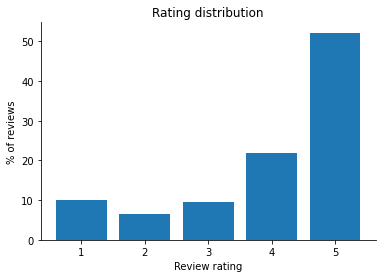

In [10]:
# Plot out number of reviews for each rating 1-5

values, counts = np.unique(nyc_full['rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
sns.despine()
plt.title("Rating distribution")
plt.show()

In [11]:
nyc_df = nyc_full[['rating', 'text']]

In [12]:
nyc_df['rating'] = np.where(nyc_df['rating'] >= 4, 1, 0)

<ipython-input-12-1ea6097ceeae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['rating'] = np.where(nyc_df['rating'] >= 4, 1, 0)


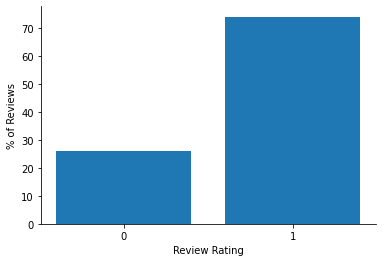

Class imbalance in NYC: [0.26 0.74]


In [13]:
values, counts = np.unique(nyc_df['rating'], return_counts=True)
normalized_counts_nyc = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts_nyc*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
sns.despine()
plt.show()

print(f"Class imbalance in NYC: {np.round(normalized_counts_nyc, 2)}")

In [14]:
# nyc
X_nyc = nyc_df['text']
y_nyc = nyc_df['rating']

In [15]:
neg_reviews = np.where(nyc_df['rating'] == 0)

In [16]:
neg = nyc_df.iloc[neg_reviews]
neg

,rating,text
0,0,TERRIBLE! TERRIBLE! Worst customer service eve...
1,0,Rudest and unprofessional workers ever \nI wou...
2,0,We came to the museum to see the Leonard Cohen...
5,0,Burnt bagel. Such a disappointing experience. ...
6,0,Ordered breakfast burritos from this place. Th...
...,...,...
4190,0,This place is very small and new to 125th st. ...
4200,0,Decent bagel spot in central Harlem. Unlike so...
4203,0,I only give a 2 (and not a one) to the brownie...
4205,0,Mediocre service and extortionately expensive....


In [17]:
pos_reviews = np.where(nyc_df['rating'] == 1)

In [18]:
pos = nyc_df.iloc[pos_reviews]
pos

,rating,text
3,1,Definitely pricey but it's every dessert-lover...
4,1,We like to get egg and cheese bagels here on t...
8,1,For many years a married couple I was friends ...
9,1,"Always good to see a place named after you, #K..."
10,1,I ordered breakfast from this cafe via Uber Ea...
...,...,...
4211,1,KOFI Coffee & Bakery is wonderful. It's beauti...
4213,1,Been waiting for Bambu near me to open and it'...
4214,1,This is the cutest family bakery! If you're lo...
4215,1,"The my are open again, got my pastrami fix!! S..."


In [19]:
neg_reviews = neg
pos_reviews = pos

In [21]:
neg_reviews.drop(columns=['rating'], inplace=True)
pos_reviews.drop(columns=['rating'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
neg_reviews

,text
0,TERRIBLE! TERRIBLE! Worst customer service eve...
1,Rudest and unprofessional workers ever \nI wou...
2,We came to the museum to see the Leonard Cohen...
5,Burnt bagel. Such a disappointing experience. ...
6,Ordered breakfast burritos from this place. Th...
...,...
4190,This place is very small and new to 125th st. ...
4200,Decent bagel spot in central Harlem. Unlike so...
4203,I only give a 2 (and not a one) to the brownie...
4205,Mediocre service and extortionately expensive....


In [23]:
# Convert to array
neg_reviews = neg_reviews[['text']].to_numpy()

In [24]:
# Convert to array
pos_reviews = pos_reviews[['text']].to_numpy()

In [25]:
neg_reviews = neg_reviews.flatten()

In [26]:
pos_reviews = pos_reviews.flatten()

In [27]:
from sklearn.feature_extraction import text

In [28]:
stop_words = text.ENGLISH_STOP_WORDS

In [29]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 2000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'bagels':'bagel', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 353 ms, sys: 15.8 ms, total: 369 ms
Wall time: 400 ms


In [30]:
# Store TFIDF vectors in a df for later use
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each word
# high mean = important
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [31]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('bagel',), ('coffee',), ('good',), ('place',), ('great',), ('order',), ('food',), ('cheese',)]
Top 8 words in NEGATIVE reviews:[('bagel',), ('order',), ('place',), ('coffee',), ('food',), ('good',), ('cheese',), ('just',)]


In [32]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert to gensim corpus
# Transpose
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [33]:
# LSA model
num_topics = 20
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

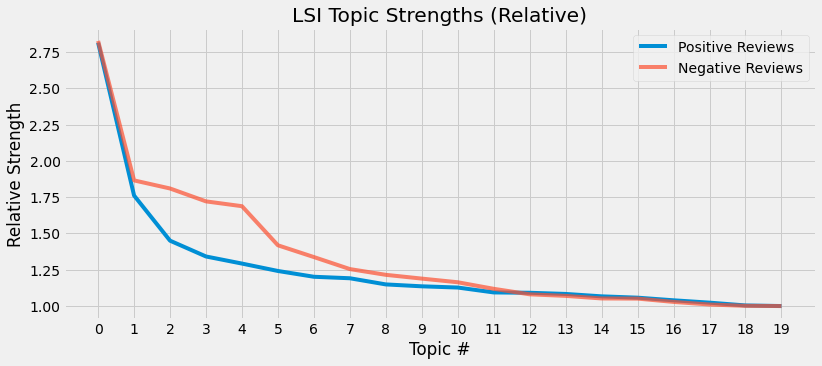

In [34]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [35]:
topics = 5

In [36]:
# check out top 5 positive topics
print('Top %d topics for POSITIVE reviews' %(topics))
print('-'*33)
print(lsi_pos.show_topics()[0:topics])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0, '0.368*"bagel" + 0.204*"coffee" + 0.196*"good" + 0.187*"place" + 0.182*"great" + 0.161*"cheese" + 0.148*"order" + 0.138*"food" + 0.121*"cream" + 0.120*"delicious"'), (1, '0.733*"bagel" + 0.215*"cheese" + 0.213*"cream" + -0.207*"coffee" + -0.118*"food" + -0.113*"great" + -0.101*"cookie" + -0.098*"place" + -0.089*"love" + 0.080*"lox"'), (2, '-0.431*"cookie" + -0.282*"black" + -0.280*"white" + -0.278*"cookies" + 0.221*"coffee" + -0.169*"cake" + -0.144*"sweet" + -0.129*"vanilla" + -0.118*"bakery" + -0.103*"treat"'), (3, '-0.350*"bambu" + 0.304*"coffee" + -0.194*"waffle" + -0.194*"drink" + -0.185*"getting" + -0.155*"addict" + -0.155*"favors" + -0.148*"cashier" + -0.146*"order" + -0.146*"opinion"'), (4, '-0.387*"coffee" + 0.306*"food" + -0.218*"bambu" + 0.182*"good" + 0.161*"sandwich" + 0.154*"deli" + -0.152*"shop" + 0.141*"chicken" + 0.123*"sandwiches" + -0.115*"bagel"')]


In [37]:
# check out top 5 negative topics
print('Top %d topics for NEGATIVE reviews' %(topics))
print('-'*33)
print(lsi_neg.show_topics()[0:topics])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0, '0.399*"bagel" + 0.207*"cheese" + 0.195*"order" + 0.179*"place" + 0.169*"cream" + 0.166*"coffee" + 0.158*"good" + 0.153*"food" + 0.150*"just" + 0.124*"like"'), (1, '0.397*"bagel" + -0.311*"brownies" + 0.229*"cream" + 0.214*"cheese" + -0.186*"greenberg" + -0.172*"cookies" + -0.163*"original" + -0.142*"shop" + -0.124*"william" + -0.120*"memory"'), (2, '0.334*"bagel" + 0.236*"brownies" + 0.190*"cream" + 0.166*"cheese" + -0.164*"brew" + -0.164*"lily" + -0.161*"tastes" + -0.160*"ice" + -0.159*"cute" + -0.157*"watery"'), (3, '-0.398*"brownies" + -0.250*"bagel" + -0.168*"cream" + -0.167*"lily" + -0.167*"brew" + -0.159*"tastes" + -0.158*"ice" + -0.156*"double" + -0.153*"large" + -0.152*"watery"'), (4, '-0.380*"brownies" + 0.202*"greenberg" + 0.183*"bagel" + 0.155*"shop" + 0.135*"william" + 0.130*"memory" + 0.125*"lily" + 0.125*"brew" + 0.119*"cream" + 0.118*"tastes"')]


In [38]:
%%time
# negative values in LSA topics are not working
# could have better luck with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


CPU times: user 618 ms, sys: 123 ms, total: 742 ms
Wall time: 386 ms


In [39]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.009*food, 0.878*good, 0.578*great, 0.577*place, 0.574*sandwich, 0.562*order
Topic 1:   2.078*bagel, 0.675*cheese, 0.635*cream, 0.251*egg, 0.222*toasted, 0.221*lox
Topic 2:   0.988*cookie, 0.639*cookies, 0.631*black, 0.626*white, 0.396*cake, 0.372*sweet
Topic 3:   0.945*bambu, 0.587*drink, 0.582*waffle, 0.577*getting, 0.486*favors, 0.486*addict
Topic 4:   1.589*coffee, 0.485*shop, 0.442*great, 0.372*cute, 0.366*place, 0.357*spot
Topic 5:   0.678*vietnamese, 0.572*nyc, 0.521*happy, 0.498*homesickness, 0.498*cali, 0.493*summers

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.909*coffee, 0.742*good, 0.738*place, 0.562*food, 0.559*sandwich, 0.490*just
Topic 1:   3.630*brownies, 0.907*map, 0.907*wg, 0.907*reaking, 0.907*shrunken, 0.905*recipe
Topic 2:   2.407*bagel, 1.233*cheese, 1.219*cream, 0.326*egg, 0.324*toasted, 0.288*order
Topic 3:   0.738*brew, 0.

In [40]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

563
This place is AMAZING!! Delicious food and great service. You won't go wrong with any of the food. Highly recommend.


In [41]:
# compute cosine similarities of this review wiht the rest
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [42]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
The food here is so good! Fresh food with a island vibe! I loved this place for Brunch since the pandemic I order my food to go and nothing has changed! The Salmon burger is a must try and the ginger mimosas are my favorite.
--------------------------------------------------
>> Similarity 1.000
Deli offers a variety of food options for everyone who wants to eat. Eatery options from Beef Patties to Sandwiches and salads. Everyone should feel the price selection is great. Right on the ave for tourists to stop by and get some food. Third avenue and east 110th street is a busy place morning or evening!
--------------------------------------------------
>> Similarity 1.000
This place is AMAZING!! Delicious food and great service. You won't go wrong with any of the food. Highly recommend.
--------------------------------------------------


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [44]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [45]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 3min 10s, sys: 8.11 s, total: 3min 18s
Wall time: 4min 43s


In [46]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
print(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
print(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0, '0.021*"coffee" + 0.014*"place" + 0.011*"great" + 0.010*"ve" + 0.009*"good" + 0.008*"shop" + 0.008*"staff"'), (1, '0.020*"bagel" + 0.014*"great" + 0.012*"cheese" + 0.011*"just" + 0.008*"order" + 0.008*"delicious" + 0.008*"good"'), (2, '0.024*"bagel" + 0.023*"good" + 0.017*"place" + 0.014*"order" + 0.012*"food" + 0.010*"coffee" + 0.010*"great"'), (3, '0.019*"coffee" + 0.013*"bagel" + 0.010*"good" + 0.009*"delicious" + 0.009*"order" + 0.009*"great" + 0.008*"just"'), (4, '0.013*"good" + 0.011*"bambu" + 0.011*"food" + 0.009*"delicious" + 0.009*"like" + 0.009*"got" + 0.008*"bakery"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0, '0.051*"bagel" + 0.020*"cheese" + 0.017*"cream" + 0.017*"order" + 0.014*"place" + 0.012*"good" + 0.011*"just"'), (1, '0.024*"order" + 0.010*"place" + 0.010*"sandwich" + 0.009*"cheese" + 0.009*"service" + 0.008*"time" + 0.008*"bagel"'), (2, '0

In [47]:
# let's double check the positive topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.009*food, 0.878*good, 0.578*great, 0.577*place, 0.574*sandwich, 0.562*order
Topic 1:   2.078*bagel, 0.675*cheese, 0.635*cream, 0.251*egg, 0.222*toasted, 0.221*lox
Topic 2:   0.988*cookie, 0.639*cookies, 0.631*black, 0.626*white, 0.396*cake, 0.372*sweet
Topic 3:   0.945*bambu, 0.587*drink, 0.582*waffle, 0.577*getting, 0.486*favors, 0.486*addict
Topic 4:   1.589*coffee, 0.485*shop, 0.442*great, 0.372*cute, 0.366*place, 0.357*spot
Topic 5:   0.678*vietnamese, 0.572*nyc, 0.521*happy, 0.498*homesickness, 0.498*cali, 0.493*summers


In [48]:
# let's look at a random positive review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #657
-------------------------
Always providing the best rotisserie chicken, rice & beans & sweet plantains in Harlem.
-------------------------
Topic 2: 0.0326
Topic 0: 0.0276
Topic 3: 0.0071
Topic 4: 0.0021
Topic 1: 0.0000
Topic 5: 0.0000


In [49]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.909*coffee, 0.742*good, 0.738*place, 0.562*food, 0.559*sandwich, 0.490*just
Topic 1:   3.630*brownies, 0.907*map, 0.907*wg, 0.907*reaking, 0.907*shrunken, 0.905*recipe
Topic 2:   2.407*bagel, 1.233*cheese, 1.219*cream, 0.326*egg, 0.324*toasted, 0.288*order
Topic 3:   0.738*brew, 0.738*lily, 0.715*tastes, 0.714*ice, 0.698*double, 0.697*outdoor
Topic 4:   0.813*greenberg, 0.632*shop, 0.542*william, 0.526*memory, 0.461*cookies, 0.453*original
Topic 5:   0.803*order, 0.437*service, 0.421*delivery, 0.408*restaurant, 0.383*food, 0.355*customer


In [50]:
# now let's look at a random negative review and see the topic distribution of the review
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #1446
-------------------------
I was initially impressed that a bagel in this neighborhood would only be $2.25. The bagel behind the counter looked big and fresh. I order a plain bagel with scallion cream cheese. I paid and was on my way. Upon opening the bagel outside, I realized why the bagel was priced as it was. The bagel behind the counter was not the bagel I had gotten. Mine was absolutely tiny and I kid you not, there was no more than a teaspoon of the cream cheese on it. Only about half my bites had any cream cheese at all. A laughably small amount of cream cheese. It was hard to eat, and I was very annoyed. Horrible, horrible experience, and I had to go somehwere else to fill up. I also almost bought a small naked juice until I realized it was over $6. I will never go back there again. I wish I had taken a picture of the joke of a bagel. I downloaded yelp just to warn others of this place.
-------------------------
Topic 2: 0.1965
Topic 1: 0.0010
Topic 0: 0.00

In [51]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  3,120
Negative Reviews:  1,095


In [52]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words 
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 395 ms, sys: 83.9 ms, total: 479 ms
Wall time: 775 ms


In [53]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


CPU times: user 658 ms, sys: 139 ms, total: 797 ms
Wall time: 622 ms


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [54]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.241*coffee, 0.835*great, 0.741*good, 0.712*food, 0.663*place, 0.570*service
Topic 1:   2.224*bagel, 0.733*cheese, 0.645*cream, 0.277*egg, 0.268*order, 0.239*lox
Topic 2:   1.064*cookie, 0.767*black, 0.758*white, 0.591*cookies, 0.422*bakery, 0.343*cake
Topic 3:   0.588*dessert, 0.509*ve, 0.496*staff, 0.487*bambu, 0.442*honestly, 0.424*near
Topic 4:   0.749*bambu, 0.576*waffle, 0.512*getting, 0.480*drink, 0.438*favors, 0.434*addict
Topic 5:   0.894*vietnamese, 0.690*nyc, 0.545*happy, 0.514*desserts, 0.470*presence, 0.470*summers

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   0.977*coffee, 0.646*good, 0.628*place, 0.475*sandwich, 0.434*just, 0.428*like
Topic 1:   1.687*bagel, 0.853*cream, 0.852*cheese, 0.247*toasted, 0.193*lox, 0.190*egg
Topic 2:   0.812*greenberg, 0.631*shop, 0.542*william, 0.519*memory, 0.458*cookies, 0.453*original
Topic 3:   1.657*brownies, 0.415*recipe, 0

In [55]:
# create topic dictionaries
pos_topics = {0:'service', 1:'bagel', 2:'pastries', 
              3:'staff', 4:'atmosphere', 5:'local_exp'}

neg_topics = {0:'cafe', 1:'bagel/ingredients', 2:'neighborhood', 
              3:'atmosphere', 4:'negative_food_exp', 5:'service'}

In [56]:
nyc_full

,res_name,cus_name,cus_location,text,rating,date
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22
...,...,...,...,...,...,...
4212,New York Hot & Fresh Bagels,Phil H.,"New York, NY",With the closing of my old bagel standby (Bage...,3,2016-11-06
4213,BAMBU,Dom G.,"New York, NY",Been waiting for Bambu near me to open and it'...,5,2021-05-06
4214,Friendly Bakery,Lindsay K.,"New York, NY",This is the cutest family bakery! If you're lo...,5,2020-04-07
4215,Broadway Restaurant,Lawrence L.,"New York, NY","The my are open again, got my pastrami fix!! S...",5,2020-09-22


In [57]:
pos_df = np.where(nyc_full['rating'] >=4)

In [59]:
df_pos = nyc_df.iloc[pos_df]

In [60]:
neg_df = np.where(nyc_full['rating'] < 4)

In [61]:
df_neg = nyc_df.iloc[neg_df]

In [63]:
business_names = nyc_full['res_name']

In [64]:
df_pos = df_pos.join(business_names)

In [65]:
df_pos

,rating,text,res_name
3,1,Definitely pricey but it's every dessert-lover...,Butterfield Market
4,1,We like to get egg and cheese bagels here on t...,Wu & Nussbaum
8,1,For many years a married couple I was friends ...,1 Up Bistro
9,1,"Always good to see a place named after you, #K...",KOFI Coffee & Bakery
10,1,I ordered breakfast from this cafe via Uber Ea...,Love Cafe
...,...,...,...
4211,1,KOFI Coffee & Bakery is wonderful. It's beauti...,KOFI Coffee & Bakery
4213,1,Been waiting for Bambu near me to open and it'...,BAMBU
4214,1,This is the cutest family bakery! If you're lo...,Friendly Bakery
4215,1,"The my are open again, got my pastrami fix!! S...",Broadway Restaurant


In [66]:
df_neg = df_neg.join(business_names)

In [67]:
nyc_full['review_length'] = nyc_full['text'].map(len)

In [68]:
nyc_full

,res_name,cus_name,cus_location,text,rating,date,review_length
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02,846
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03,931
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17,1260
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16,515
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22,575
...,...,...,...,...,...,...,...
4212,New York Hot & Fresh Bagels,Phil H.,"New York, NY",With the closing of my old bagel standby (Bage...,3,2016-11-06,723
4213,BAMBU,Dom G.,"New York, NY",Been waiting for Bambu near me to open and it'...,5,2021-05-06,353
4214,Friendly Bakery,Lindsay K.,"New York, NY",This is the cutest family bakery! If you're lo...,5,2020-04-07,461
4215,Broadway Restaurant,Lawrence L.,"New York, NY","The my are open again, got my pastrami fix!! S...",5,2020-09-22,89


In [69]:
review_lengths = nyc_full['review_length']
review_lengths

0        846
1        931
2       1260
3        515
4        575
        ... 
4212     723
4213     353
4214     461
4215      89
4216     764
Name: review_length, Length: 4215, dtype: int64

In [70]:
df_pos = df_pos.join(review_lengths)
df_neg = df_neg.join(review_lengths)

In [71]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.01838562 0.00381156 0.01217081 0.03248403 0.02466354 0.01145933]
Sum of weights:  0.10297489787787108


In [72]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.17854469 0.03701446 0.11819199 0.31545584 0.23951025 0.11128276]]
Sum of normalized weights:  0.9999999999999999


In [73]:
df_pos_test = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg_test = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [74]:
df_pos_test.dropna(inplace=True)

In [75]:
df_pos_test

,rating,text,res_name,review_length,0,1,2,3,4,5
3,1.0,Definitely pricey but it's every dessert-lover...,Butterfield Market,515.0,0.781071,0.000000,0.000000,0.000000,0.000000,0.218929
4,1.0,We like to get egg and cheese bagels here on t...,Wu & Nussbaum,575.0,0.510588,0.039678,0.041785,0.000000,0.407948,0.000000
8,1.0,For many years a married couple I was friends ...,1 Up Bistro,1076.0,0.362304,0.136417,0.372826,0.000000,0.098038,0.030414
9,1.0,"Always good to see a place named after you, #K...",KOFI Coffee & Bakery,336.0,0.481841,0.046995,0.173930,0.283806,0.000000,0.013428
10,1.0,I ordered breakfast from this cafe via Uber Ea...,Love Cafe,279.0,0.245481,0.367353,0.337790,0.036966,0.012411,0.000000
...,...,...,...,...,...,...,...,...,...,...
3113,1.0,Sweet deliciousness is ALL I can say! This pla...,Super Nice Coffee and Bakery,528.0,0.870354,0.063185,0.066462,0.000000,0.000000,0.000000
3115,1.0,I ordered from delivery from here and everythi...,Blue Moon Deli,527.0,0.635901,0.000000,0.364099,0.000000,0.000000,0.000000
3117,1.0,"OMG!! Barney, where have you been all my life?...",Barney Greengrass,736.0,0.259493,0.198546,0.262011,0.250571,0.029378,0.000000
3118,1.0,I love cafes and recently just been having a c...,The Chai Spot,380.0,0.647241,0.000000,0.000000,0.000000,0.352759,0.000000


In [77]:
df_neg_test.dropna(inplace=True)

In [78]:
# group by res_name and apply mean/count functions to columns
df_pos_bsns = df_pos_test.groupby('res_name').agg({'rating':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg_test.groupby('res_name').agg({'rating':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [80]:
df_neg_bsns

,res_name,rating,text,review_length,0,1,2,3,4,5
0,1 Up Bistro,0.0,1,749.000000,0.915663,0.000000,0.000000,0.033615,0.050722,0.000000
1,84th Street Corner Deli,0.0,8,432.250000,0.506607,0.142178,0.025083,0.023088,0.077822,0.225223
2,Absolute Bagels,0.0,3,650.333333,0.058224,0.238436,0.000000,0.000000,0.032803,0.670537
3,Andy’s Restaurant,0.0,2,400.000000,0.262123,0.214213,0.019336,0.205165,0.176116,0.123048
4,Astoria Deli Grocery MY Corp,0.0,3,897.666667,0.183724,0.368061,0.007883,0.113103,0.071895,0.255334
...,...,...,...,...,...,...,...,...,...,...
118,Yorkville Bagel & Cafe,0.0,2,696.000000,0.583352,0.394345,0.000000,0.000000,0.022303,0.000000
119,Yura on Madison,0.0,2,1118.000000,0.457063,0.000000,0.036412,0.027855,0.075438,0.403232
120,Zabar’s,0.0,1,1069.000000,0.889723,0.042194,0.000000,0.000000,0.068083,0.000000
121,Zaro’s Family Bakery,0.0,1,134.000000,0.406438,0.013715,0.046840,0.028336,0.000000,0.504672


In [81]:
%%time
# Write them to CSV and use info for visualizations in Flourish
df_pos_bsns.to_csv('data/pos_bsns_nyc.csv')
df_neg_bsns.to_csv('data/neg_bsns_nyc.csv')

CPU times: user 15.5 ms, sys: 14.2 ms, total: 29.7 ms
Wall time: 60.8 ms


In [82]:
nyc_full

,res_name,cus_name,cus_location,text,rating,date,review_length
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02,846
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03,931
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17,1260
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16,515
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22,575
...,...,...,...,...,...,...,...
4212,New York Hot & Fresh Bagels,Phil H.,"New York, NY",With the closing of my old bagel standby (Bage...,3,2016-11-06,723
4213,BAMBU,Dom G.,"New York, NY",Been waiting for Bambu near me to open and it'...,5,2021-05-06,353
4214,Friendly Bakery,Lindsay K.,"New York, NY",This is the cutest family bakery! If you're lo...,5,2020-04-07,461
4215,Broadway Restaurant,Lawrence L.,"New York, NY","The my are open again, got my pastrami fix!! S...",5,2020-09-22,89


In [83]:
from geopy.geocoders import Nominatim

In [84]:
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode("New York City, NY")

In [85]:
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 40.7127281, Longitude = -74.0060152


In [86]:
from geopy.extra.rate_limiter import RateLimiter

In [87]:
pip install ipywidgets

  Using cached ipywidgets-7.6.3-py2.py3-none-any.whl (121 kB)


Note: you may need to restart the kernel to use updated packages.


In [88]:
# 1 - function to delay between geocoding calls 
geocode = RateLimiter(locator.geocode, min_delay_seconds = 0.2)
# 2 - create location column 
nyc_full['location'] = nyc_full['cus_location'].apply(geocode)
# 3 - create longitude, latitude and altitude from location column (returns tuple)
nyc_full['point'] = nyc_full['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into lat, long and alt columns
nyc_full[['lat', 'long', 'alt']] = pd.DataFrame(nyc_full['point'].tolist(), index=nyc_full.index)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

RateLimiter caught an error, retrying (1/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

RateLimiter caught an error, retrying (1/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

RateLimiter caught an error, retrying (1/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

RateLimiter caught an error, retrying (1/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

RateLimiter caught an error, retrying (1/2 tries). Called with (*('East Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/

RateLimiter swallowed an error after 2 retries. Called with (*('West Bronx, NY',), **{}).
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 1332, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Lib

In [89]:
nyc_full

,res_name,cus_name,cus_location,text,rating,date,review_length,location,point,lat,long,alt
0,Juliano Gourmet Coffee,Brian C.,"Manhattan, NY",TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02,846,"(Manhattan, New York County, New York, United ...","(40.7896239, -73.9598939, 0.0)",40.789624,-73.959894,0.0
1,II Caffe Latte 2,Lenis M.,"Bronx, New York, NY",Rudest and unprofessional workers ever \nI wou...,1,2019-12-03,931,"(The Bronx, Bronx County, New York, United Sta...","(40.8466508, -73.8785937, 0.0)",40.846651,-73.878594,0.0
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,"Pompano Beach, FL",We came to the museum to see the Leonard Cohen...,3,2019-05-17,1260,"(Pompano Beach, Broward County, Florida, Unite...","(26.2378597, -80.1247667, 0.0)",26.237860,-80.124767,0.0
3,Butterfield Market,Ellen J.,"New York, NY",Definitely pricey but it's every dessert-lover...,4,2021-04-16,515,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0
4,Wu & Nussbaum,Adam F.,"New York, NY",We like to get egg and cheese bagels here on t...,5,2020-09-22,575,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4212,New York Hot & Fresh Bagels,Phil H.,"New York, NY",With the closing of my old bagel standby (Bage...,3,2016-11-06,723,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0
4213,BAMBU,Dom G.,"New York, NY",Been waiting for Bambu near me to open and it'...,5,2021-05-06,353,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0
4214,Friendly Bakery,Lindsay K.,"New York, NY",This is the cutest family bakery! If you're lo...,5,2020-04-07,461,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0
4215,Broadway Restaurant,Lawrence L.,"New York, NY","The my are open again, got my pastrami fix!! S...",5,2020-09-22,89,"(New York, United States, (40.7127281, -74.006...","(40.7127281, -74.0060152, 0.0)",40.712728,-74.006015,0.0


In [91]:
nyc_customer_locations = nyc_full.drop(columns=["review_length", 'location', 'alt', 'point', 'cus_location'])

nyc_customer_locations.head()

,res_name,cus_name,text,rating,date,lat,long
0,Juliano Gourmet Coffee,Brian C.,TERRIBLE! TERRIBLE! Worst customer service eve...,1,2019-11-02,40.789624,-73.959894
1,II Caffe Latte 2,Lenis M.,Rudest and unprofessional workers ever \nI wou...,1,2019-12-03,40.846651,-73.878594
2,Russ & Daughters at the Jewish Museum - Temp. ...,Julie F.,We came to the museum to see the Leonard Cohen...,3,2019-05-17,26.237860,-80.124767
3,Butterfield Market,Ellen J.,Definitely pricey but it's every dessert-lover...,4,2021-04-16,40.712728,-74.006015
4,Wu & Nussbaum,Adam F.,We like to get egg and cheese bagels here on t...,5,2020-09-22,40.712728,-74.006015


In [92]:
compression_opts = dict(method='zip', archive_name='out.csv')
nyc_customer_locations.to_csv(index=False, compression=compression_opts)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/common.py:558: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  ioargs = _get_filepath_or_buffer(


'res_name,cus_name,text,rating,date,lat,long\nJuliano Gourmet Coffee,Brian C.,"TERRIBLE! TERRIBLE! Worst customer service ever. I recently went into this place for a cup of coffee. I\'ve walked by it a million times, but have never tried it out. I was walking to work and pushing my son in his stroller. Despite the fact that my son was quiet and well-behaved, I wish I had taken pictures of the death stares that I got from the cashier and baristas. They all looked at me like I walked in with bloody knives and a dead animal. Seriously, this place is located on the UES, which is one of the most family-friendly neighborhoods in Manhattan. Yet this place is perhaps the most family UN-friendly place I\'ve ever been to in NYC. Stay far far away from this place. There are so many other options in the area that serve better-quality coffee anyway. I\'ll be telling all of my friends and neighbors to never patronize this place.",1,2019-11-02,40.7896239,-73.9598939\nII Caffe Latte 2,Lenis M.,"Rudest

In [93]:
nyc_customer_locations.to_csv('nyc_lat_long.csv') # relative position
# mtl_customer_locations.to_csv('/Users/setadrift/Downloads/')